In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
from __future__ import division
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import sys
from IPython.core.display import display, HTML
sns.set_context({'figure.figsize': [12, 7]})
sns.set_context(rc={'lines.markeredgewidth': 0.1})
sns.set_style('white')
sns.set_color_codes()
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import pairwise_distances
print 'startup script successful'

Populating the interactive namespace from numpy and matplotlib
startup script successful


In [2]:
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
# some utility functions

In [4]:
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords


token_pattern = re.compile(r"(?u)\b\w\w+\b")
stop_list=stopwords.words('english')+['help','new', 'way', 'world', 'make', 'people']


def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in token_pattern.findall(doc)]
    
def plot_top_words(model, feature_names, topic_idx, n_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
    topic=normalize(model.components_[topic_idx].reshape(1,-1))[0]
    sorted_idx=topic.argsort()[:-n_top_words - 1:-1]
    print("Topic #%d:" % topic_idx)
    features=[feature_names[i] for i in sorted_idx]
    print(" ".join(features))
    ax = sns.barplot(x=range(10),y=topic[sorted_idx])
    feature_id=0
    height= max(topic[sorted_idx])*0.6

    for p in ax.patches:
        ax.text(p.get_x()+0.15, height-0.1, '{}'.format(features[feature_id]))
        feature_id+=1

In [5]:
# load company data and combine them, 

In [6]:
crunch_data=pd.read_csv('overall_company_list.csv')
kickstart_data=pd.read_csv('proj_list_tech_top200pages_full.csv')
angellist_data=pd.read_csv('results_so_far_2016101710pm.csv')
# unify the column name
kickstart_data.rename(columns={'description':'Description'},inplace=True)
angellist_data.rename(columns={'product_desc':'Description'},inplace=True)
#merge data
merge_data=crunch_data.append([kickstart_data,angellist_data])
# remove \n from descriptions
merge_data['Description']=merge_data['Description'].str.replace('\n',' ')
# merge_data['Description']=merge_data['Description'].str.replace('\\',' ')

merge_data=merge_data.dropna(subset=['Description'])

In [7]:
# build TF-IDF feature and NMF topic model

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2,
                                   max_features=3000,
                                   tokenizer=LemmaTokenizer(),
                                   stop_words=stop_list)
tfidf = tfidf_vectorizer.fit_transform(merge_data['Description'])
nmf = NMF(n_components=15, random_state=1, 
          alpha=.1, l1_ratio=.2, max_iter=5000).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
topic_feature=nmf.transform(tfidf)
topic_feature_norm=normalize(topic_feature)

Topic #0:
user product online customer experience video com use create one
Topic #1:
data big science driven visualization analysis machine insight enterprise learning
Topic #2:
platform engagement management cloud online customer enables audience content advertising
Topic #3:
intelligence artificial machine enterprise competitive human powered ai learning cyber
Topic #4:
analytics predictive provides retail advanced tool healthcare financial sale store
Topic #5:
mobile application app web apps user development device game developer
Topic #6:
social medium network content brand engagement networking discovery audience optimization
Topic #7:
marketing digital agency brand advertising automation marketer performance content sale
Topic #8:
based location cloud user offer game app sharing networking interest
Topic #9:
real time estate insight place delivers information analysis feedback news
Topic #10:
business small customer local intelligence sale insight tool information process
Topic #

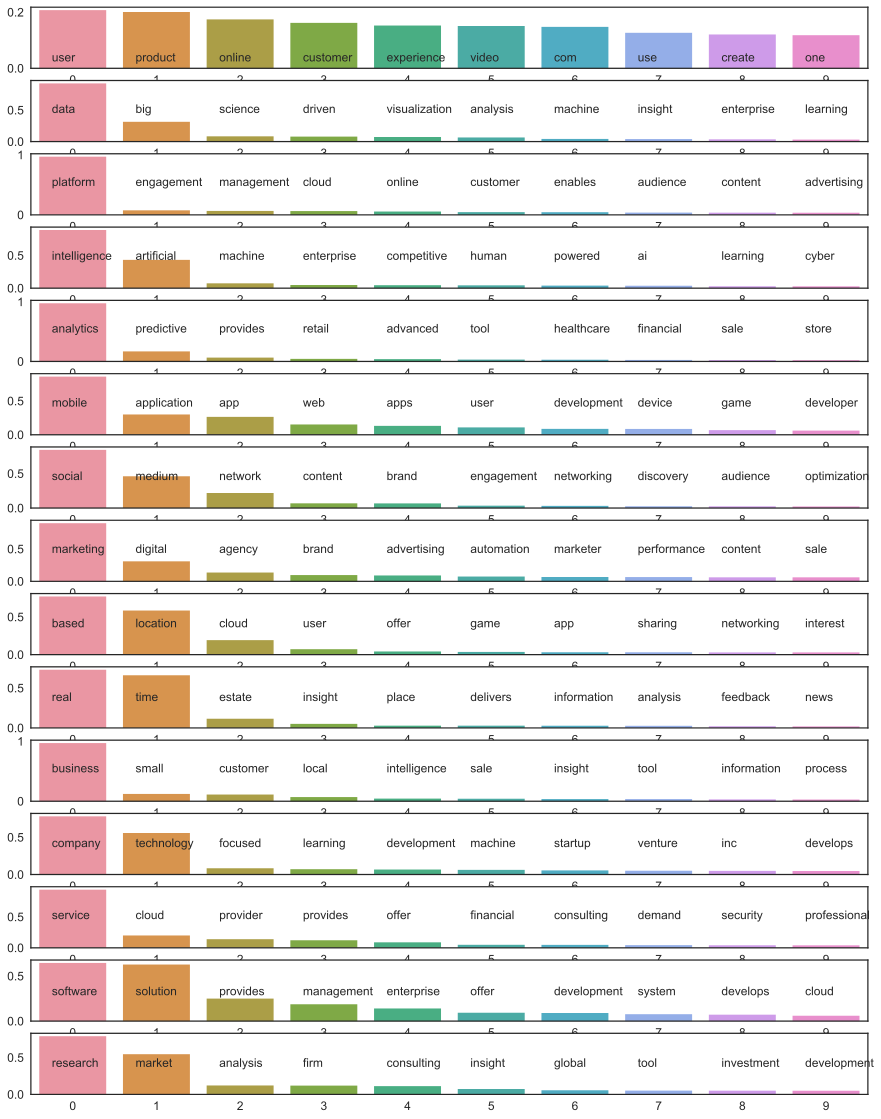

In [9]:
# plot the topics 
fig=figure(figsize=(15,20))
for i in range(15):
    subplot(15,1,i+1)
    plot_top_words(nmf,tfidf_feature_names,i)

In [10]:
# cluster the companies

In [11]:
import itertools
palette = itertools.cycle(sns.hls_palette(15))
markers= itertools.cycle(['x','o','v','^','<','s'])

In [12]:
def plot_cluster(model, features, tsne_features, feature_names, nmf_model=nmf):
    """
    model: the clustering model. model.labels_ should contain the clusting label
    features: feature vectors used to compute the clustering centroid
    tsne_features: feature vectors for plot with tsne
    """
    cluster_labels=model.labels_
    n_top_words=10
    num_clusters=max(cluster_labels)+1
    # plotting
    # sample 2000 data points for scattering plot
    sample_for_plt, label_for_plt=resample(tsne_features,cluster_labels,n_samples=2000,random_state=0)
    mapping = TSNE(n_components=2,init='random', random_state=0, n_iter=2000, verbose=0, learning_rate=100, perplexity=20)
    embed=mapping.fit_transform(sample_for_plt)
    fig=figure(figsize=(15,7))
    # plot the clusters
    subplot(1,2,1)
    for i in range(num_clusters):
        subgroup=embed[label_for_plt==i,:]
        scatter(subgroup[:,0],subgroup[:,1],s=15, color=next(palette), marker=next(markers), label='{}'.format(i))
    legend()
    # plot the histgram of the clusters 
    subplot(1,2,2)
    hist(cluster_labels)
    # print out the cluster centers
    fig=figure(figsize=(15,10))
    for i in range(max(cluster_labels)+1):
        cluster=features[cluster_labels==i,:]
        centroid=np.mean(cluster,axis=0)
        centroid_feature=centroid.dot(nmf_model.components_)
        sorted_idx=centroid_feature.argsort()[:-n_top_words - 1:-1]
        subplot(num_clusters,1,i+1)
        ax = sns.barplot(x=range(10),y=centroid_feature[sorted_idx])
        top_words=[feature_names[j] for j in sorted_idx]
        word_id=0
        height= max(centroid_feature[sorted_idx])*0.6
        for p in ax.patches:
            ax.text(p.get_x()+0.15, height, '{}'.format(top_words[word_id]))
            word_id+=1


def print_cluster_member(model, cluster_id, data, num_samples=10):
    cluster_member=data.iloc[model.labels_==cluster_id]
    print 'number of companies in this class:', len(cluster_member)
    for m in cluster_member.head(num_samples).iterrows():
        print 'company ID:', m[0]
        print m[1]['Description']

In [13]:
from sklearn.cluster import AgglomerativeClustering
agg= AgglomerativeClustering(n_clusters=7, linkage='ward')
agg.fit(topic_feature_norm)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=7,
            pooling_func=<function mean at 0x10d0305f0>)

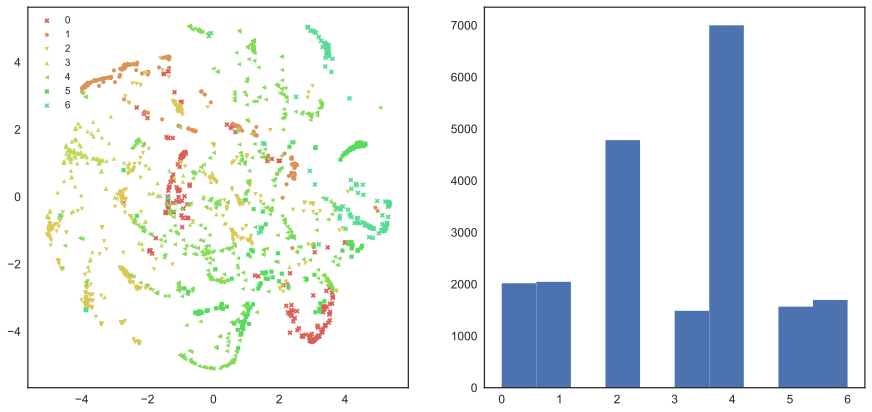

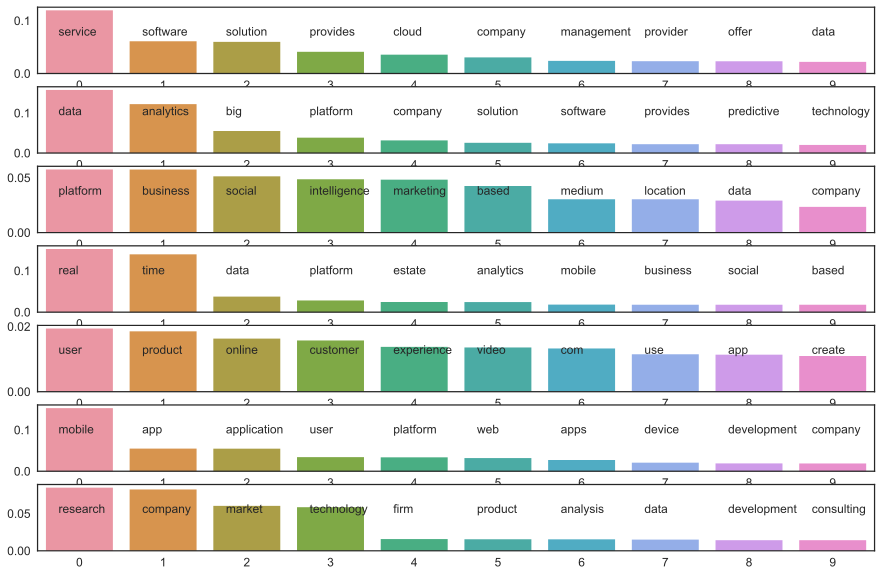

In [14]:
# query similar companies
plot_cluster(agg, topic_feature, topic_feature_norm, tfidf_feature_names)

In [15]:
from sklearn.neighbors import NearestNeighbors

In [16]:
neigh = NearestNeighbors(20, 0.4)
neigh.fit(topic_feature_norm) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=0.4)

In [17]:
def query_company(id, knn_model=neigh, data_set=merge_data, X=topic_feature_norm):
    k=10
    print 'query id:', id
    print data_set.iloc[id]['Description']
    print '-'*50
    distances, indices = knn_model.kneighbors(X[id].reshape(1, -1),n_neighbors=k)
    for i in range(1,k):
        print '{}st neighbor: id {}, with distance {}'.format(i,indices[0][i],distances[0][i])
        print  data_set.iloc[indices[0][i]]['Description']
        print 

In [18]:
query_company(3)

query id: 3
Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter.
--------------------------------------------------
1st neighbor: id 11464, with distance 0.0472617643642
OhMyBet! is an Artificial Intelligence tool for sports bettors that predicts outcomes of tennis matches using machine learning algorithms

2st neighbor: id 11456, with distance 0.0849767752587
Huma sits at the intersection between artificial intelligence and product design.

3st neighbor: id 11244, with distance 0.0912317716913
RigBasket believes in Revolutionizing Energy Together using intelligence

4st neighbor: id 5351, with distance 0.0921194159127
It is our mission is to bring the Implantable Artificial Kidney created by scientist, inventor and engineer.

5st neighbor: id 6071, with distance 0.0921194159127
It is our mission is to bring the Implantable Artificial Kidney created by scientist, inventor and engineer.

6st neighbor: id 5933, with distance 0.09509

In [19]:
label_dict = {0:'misc', 1:'big data', 2: 'mobile app', 3:'real time', 4: 'cloud service', 5:'market research', 6:'analytics'}
print label_dict

{0: 'misc', 1: 'big data', 2: 'mobile app', 3: 'real time', 4: 'cloud service', 5: 'market research', 6: 'analytics'}


In [20]:
agg.labels_.shape

(20591,)

In [21]:
merge_data.shape

(20591, 51)

In [22]:
merge_data.columns

Index([u'Categories', u'Category Groups', u'Closed Date', u'Company Name',
       u'Crunchbase Rank', u'Description', u'Founded Date',
       u'Headquarters Location', u'IPO Date', u'Last Equity Funding Amount',
       u'Last Funding Amount', u'Last Funding Date', u'Money Raised at IPO',
       u'Number of Articles', u'Number of Employees', u'Number of Founders',
       u'Number of Investors', u'Status', u'Stock Exchange', u'Stock Symbol',
       u'Total Equity Funding Amount', u'Total Funding Amount',
       u'Trend Score (30 Days)', u'Trend Score (7 Days)',
       u'Trend Score (90 Days)', u'Unnamed: 0', u'Valuation at IPO',
       u'Website', u'active', u'al_link', u'byline', u'city', u'currency',
       u'end_date', u'featured', u'funded_amt', u'funded_pct', u'headline',
       u'joined_date', u'location', u'market', u'raised', u'score', u'signal',
       u'size', u'stage', u'state', u'title', u'url', u'website', u'year'],
      dtype='object')

In [23]:
merge_data['label_cat'] = agg.labels_